In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# preprocessing of the images applied when loading image data set from disk with
# tensorflows flow_from_directory

image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )

In [4]:
# path to the image data set

train_data_path = './data/test-bed-deffects/data_balanced/train'  #local notebook
test_data_path = './data/test-bed-deffects/data_balanced/test'  #local notebook
validation_data_path = './data/test-bed-deffects/data_balanced/validation'  #local notebook

In [5]:
# generate training set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {train} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(180, 180),
                                                class_mode='binary')

Found 2000 images belonging to 2 classes.


In [6]:
# generate test set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {test} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

test_image_gen = image_gen.flow_from_directory(test_data_path,
                                               target_size=(180, 180),
                                               class_mode='binary')

Found 998 images belonging to 2 classes.


In [7]:
# generate validation set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {validation} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

valid_set = image_gen.flow_from_directory(validation_data_path,
                                          target_size=(180, 180),
                                          class_mode='binary')

Found 1000 images belonging to 2 classes.


In [8]:
# saves the model and its weights as a json file in the folder saved_models

def save_model(model, model_name):
    my_model = model.to_json()
    with open(f'./saved_models/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./saved_models/{model_name}_weights.h5')


In [9]:
# method to select the base model architecture
# pretrained with the weights of the imagenet data set
# the top layers are excluded and have to be implemented on top of the base model
# currently Vgg16, Xception, ResNet50

def build_base_model(model_selected, weights):
    if model_selected == 'vgg':
        return keras.applications.vgg16.VGG16(include_top=False, weights=weights)
    if model_selected == 'xception':
        return keras.applications.xception.Xception(include_top=False, weights=weights)
    if model_selected == 'resnet':
        return keras.applications.resnet50.ResNet50(include_top=False, weights=weights)

    # method which adds the new top layers on the base model and returns the now complete model

In [10]:
def model_builder(input_model):
    model_input = keras.Input(shape=(180, 180, 3), name='image_input')

    output_base_model = input_model(model_input)

    x = keras.layers.Flatten(name='flatten')(output_base_model)
    x = keras.layers.Dense(1000)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(model_input, x)

In [11]:
# method activate the base models layers ability to learn (be trainable)
# set to false for the first training run to not destroy the pretrained weights

def set_layers_trainable(trainable, input_model):
    for layer in input_model.layers:
        layer.trainable = trainable

In [12]:
# method to compile the model with the adam optimizer which returns the compiled model

def compile_model(input_model, alpha, beta1, beta2, metrics):
    optimizer = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
    model = model_builder(input_model)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

    return model



In [13]:
# method to train the model

def train_model(input_model, train_set, test_set, epochs, callback):
    return input_model.fit(train_set,
                           validation_data=test_set,
                           epochs=epochs,
                           callbacks=callback)

In [15]:
# NO PRETRAINING

# set base model
vgg16_base_model = build_base_model('vgg', None)

# compile model
vgg16_model = compile_model(vgg16_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
vgg_no_train_history = train_model(vgg16_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, vgg_no_train_accuracy, recall, precision, auc = vgg16_model.evaluate(valid_set)

# F1 score
vgg_no_train_f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {vgg_no_train_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {vgg_no_train_f1}")

Epoch 1/100
63/63 [==============================] - 23s 353ms/step - loss: 0.6997 - accuracy: 0.5049 - recall: 0.4953 - precision: 0.5013 - auc: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.5010 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 2/100
63/63 [==============================] - 23s 360ms/step - loss: 0.6951 - accuracy: 0.4794 - recall: 0.4592 - precision: 0.4667 - auc: 0.4795 - val_loss: 0.6932 - val_accuracy: 0.5010 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
63/63 [==============================] - 22s 355ms/step - loss: 0.6944 - accuracy: 0.4961 - recall: 0.4299 - precision: 0.4826 - auc: 0.4903 - val_loss: 0.6931 - val_accuracy: 0.5010 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 4/100
63/63 [==============================] - 25s 399ms/step - loss: 0.6947 - accuracy: 0.4798 - recall: 0.4979 - precision: 0.4789 - auc: 0.4754 - val_loss: 0.6932 - val_accuracy: 0.4990 - val_r

In [16]:
# Script which uses
# vgg16 as a base model
# the adams optimizer with learning rate: 0.0001, beta_1: 0.9 and beta_2: 0.99
# accuracy, recall, precision, auc as metrics
# trains the frozen model for 5 epochs
# defines an early stopping callback with an patience of 20
# trains the unfrozen model (for 100 epoch) till early stopping stops the training
# and prints the values of the metrics


# set base model
vgg16_base_model = build_base_model('vgg', 'imagenet')

# freeze layers of base model for first train run
set_layers_trainable(False, vgg16_base_model)

# compile model (also builds the model)
vgg16_model = compile_model(vgg16_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# train frozen layer model
vgg_history = train_model(vgg16_model, train_image_gen, test_image_gen, 5, [])

# unfreeze base model layers
set_layers_trainable(True, vgg16_base_model)

# compile model
vgg16_model = compile_model(vgg16_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
vgg_history = train_model(vgg16_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, vgg_16_accuracy, recall, precision, auc = vgg16_model.evaluate(valid_set)

# F1 score
vgg_f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {vgg_16_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {vgg_f1}")

Epoch 1/5
63/63 [==============================] - 19s 285ms/step - loss: 0.8211 - accuracy: 0.6272 - recall: 0.6544 - precision: 0.6024 - auc: 0.6801 - val_loss: 0.5608 - val_accuracy: 0.7084 - val_recall: 0.9558 - val_precision: 0.6389 - val_auc: 0.8269
Epoch 2/5
63/63 [==============================] - 18s 281ms/step - loss: 0.6796 - accuracy: 0.6730 - recall: 0.7564 - precision: 0.6265 - auc: 0.7443 - val_loss: 0.5214 - val_accuracy: 0.7515 - val_recall: 0.9438 - val_precision: 0.6812 - val_auc: 0.8291
Epoch 3/5
63/63 [==============================] - 20s 311ms/step - loss: 0.6304 - accuracy: 0.7050 - recall: 0.7720 - precision: 0.6811 - auc: 0.7720 - val_loss: 0.4652 - val_accuracy: 0.7705 - val_recall: 0.8876 - val_precision: 0.7187 - val_auc: 0.8538
Epoch 4/5
63/63 [==============================] - 18s 285ms/step - loss: 0.6524 - accuracy: 0.6919 - recall: 0.7371 - precision: 0.6778 - auc: 0.7622 - val_loss: 0.7283 - val_accuracy: 0.7244 - val_recall: 0.9819 - val_precision: 0

NameError: name 'vgg_accuracy' is not defined

In [18]:
print(f"loss: {loss}, \n"
      f"accuracy: {vgg_16_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {vgg_f1}")

loss: 0.26473912596702576, 
accuracy: 0.9139999747276306, 
recall: 0.9380000233650208, 
precision: 0.8950381875038147, 
auc: 0.9459560513496399, 
F1: 0.9160156463876774


In [22]:
# NO PRETRAINING

# set base model
xception_base_model = build_base_model('xception', None)

# compile model
xception_model = compile_model(xception_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
xception_no_train_history = train_model(xception_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, xception_no_train_accuracy, recall, precision, auc = xception_model.evaluate(valid_set)

# F1 score
xception_no_train_f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {xception_no_train_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {xception_no_train_f1}")

In [23]:
# Script which uses
# xception as a base model
# the adams optimizer with learning rate: 0.0001, beta_1: 0.9 and beta_2: 0.99
# accuracy, recall, precision, auc as metrics
# trains the frozen model for 5 epochs
# defines an early stopping callback with an patience of 20
# trains the unfrozen model (for 100 epoch) till early stopping stops the training
# and prints the values of the metrics


# set base model
xception_base_model = build_base_model('xception', 'imagenet')

# freeze layers of base model for first train run
set_layers_trainable(False, xception_base_model)

# compile model (also builds the model)
xception_model = compile_model(xception_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# train frozen layer model
xception_history = train_model(xception_model, train_image_gen, test_image_gen, 5, [])

# unfreeze base model layers
set_layers_trainable(True, xception_base_model)

# compile model
xception_model = compile_model(xception_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
xception_history = train_model(xception_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, xception_accuracy, recall, precision, auc = xception_model.evaluate(valid_set)

# F1 score
xception_f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {xception_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {xception_f1}")

Epoch 1/5
63/63 [==============================] - 18s 254ms/step - loss: 1.4697 - accuracy: 0.6860 - recall: 0.7319 - precision: 0.6747 - auc: 0.7351 - val_loss: 0.7671 - val_accuracy: 0.7515 - val_recall: 0.7088 - val_precision: 0.7741 - val_auc: 0.8404
Epoch 2/5
63/63 [==============================] - 15s 240ms/step - loss: 0.5616 - accuracy: 0.7803 - recall: 0.8484 - precision: 0.7433 - auc: 0.8460 - val_loss: 0.5095 - val_accuracy: 0.8226 - val_recall: 0.8233 - val_precision: 0.8216 - val_auc: 0.8837
Epoch 3/5
63/63 [==============================] - 15s 241ms/step - loss: 0.5460 - accuracy: 0.7780 - recall: 0.8384 - precision: 0.7475 - auc: 0.8429 - val_loss: 0.4796 - val_accuracy: 0.8146 - val_recall: 0.7691 - val_precision: 0.8455 - val_auc: 0.8927
Epoch 4/5
63/63 [==============================] - 15s 242ms/step - loss: 0.4245 - accuracy: 0.8055 - recall: 0.8648 - precision: 0.7637 - auc: 0.8926 - val_loss: 0.4503 - val_accuracy: 0.8307 - val_recall: 0.8414 - val_precision: 0

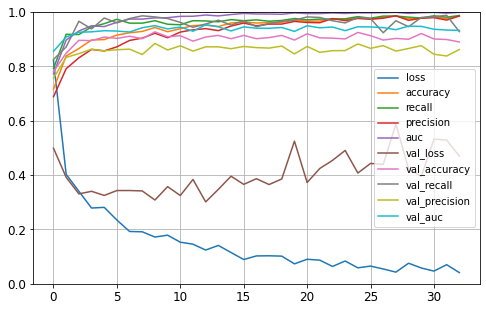

In [24]:
# NO PRETRAINING

# set base model
resnet_base_model = build_base_model('resnet', 'imagenet')

# compile model
resnet_model = compile_model(resnet_base_model, 0.00001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
resnet_no_train_history = train_model(resnet_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, resnet_no_train_accuracy, recall, precision, auc = resnet_model.evaluate(valid_set)

# F1 score
resnet_no_train_f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {resnet_no_train_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {resnet_not_train_f1}")

In [27]:
# Script which uses
# resnet as a base model
# the adams optimizer with learning rate: 0.0001, beta_1: 0.9 and beta_2: 0.99
# accuracy, recall, precision, auc as metrics
# trains the frozen model for 5 epochs
# defines an early stopping callback with an patience of 20
# trains the unfrozen model (for 100 epoch) till early stopping stops the training
# and prints the values of the metrics


# set base model
resnet_base_model = build_base_model('resnet', 'imagenet')

# freeze layers of base model for first train run
set_layers_trainable(False, resnet_base_model)

# compile model (also builds the model)
resnet_model = compile_model(resnet_base_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# train frozen layer model
resnet_history = train_model(resnet_model, train_image_gen, test_image_gen, 5, [])

# unfreeze base model layers
set_layers_trainable(True, resnet_base_model)

# compile model
resnet_model = compile_model(resnet_base_model, 0.00001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

# train complete model
resnet_history = train_model(resnet_model, train_image_gen, test_image_gen, 100, [custom_early_stopping])

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, resnet_accuracy, recall, precision, auc = resnet_model.evaluate(valid_set)

# F1 score
resnet_f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {resnet_accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {resnet_f1}")

Epoch 1/5
63/63 [==============================] - 21s 290ms/step - loss: 0.9431 - accuracy: 0.4934 - recall: 0.5026 - precision: 0.4967 - auc: 0.4819 - val_loss: 0.6883 - val_accuracy: 0.5641 - val_recall: 0.7209 - val_precision: 0.5481 - val_auc: 0.5714
Epoch 2/5
63/63 [==============================] - 17s 264ms/step - loss: 0.8666 - accuracy: 0.5105 - recall: 0.5013 - precision: 0.5082 - auc: 0.5206 - val_loss: 0.7741 - val_accuracy: 0.5020 - val_recall: 0.0040 - val_precision: 0.6667 - val_auc: 0.6244
Epoch 3/5
63/63 [==============================] - 17s 274ms/step - loss: 0.8565 - accuracy: 0.5273 - recall: 0.5382 - precision: 0.5296 - auc: 0.5318 - val_loss: 0.7443 - val_accuracy: 0.5150 - val_recall: 0.9859 - val_precision: 0.5072 - val_auc: 0.6555
Epoch 4/5
63/63 [==============================] - 16s 260ms/step - loss: 0.8429 - accuracy: 0.5148 - recall: 0.5344 - precision: 0.5077 - auc: 0.5288 - val_loss: 0.9802 - val_accuracy: 0.5010 - val_recall: 0.0000e+00 - val_precisio

ResourceExhaustedError:  OOM when allocating tensor with shape[73728,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_8/dense_16/MatMul_1 (defined at <ipython-input-15-e716234d242b>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_201946]

Function call stack:
train_function


In [ ]:
# plot loss during training
plt.subplot(211)
plt.title('Loss - no pre-training')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy - no pre training')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

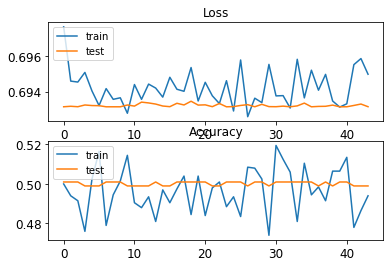

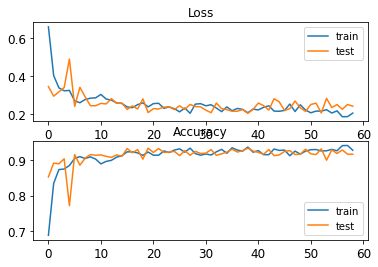

In [23]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(vgg_no_train_history.history['loss'], label='train')
plt.plot(vgg_no_train_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(vgg_no_train_history.history['accuracy'], label='train')
plt.plot(vgg_no_train_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(vgg_history.history['loss'], label='train')
plt.plot(vgg_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(vgg_history.history['accuracy'], label='train')
plt.plot(vgg_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()